Predicting Hard Drive Failures Using SMART Metrics
-----

### <img src="images/JUUL_ogo_2018.jpg" align="left" height="40" width="60"> <br> - A Juul Labs Case Study 


                            - by Harshvardhan Pandey | Jan 2019

### What are SMART systems ?
SMART features or *S.M.A.R.T. (Self-Monitoring, Analysis and Reporting Technology)* is a software monitoring system for hard drives. It is a widely used industry practice around data center management and disk heavy resources. SMART generates a collection different metrics related to help evaluate the overall health of a Hard Drive. These metrics can be specific to a certain number of manufacturers or be more general, sometimes. 

A single metrics may not always determine the exact failure prediction but are commonly accepted to help identify any imminent failure and help handle the backup and restore, in time. 


### About this case study :
This case study relies on a given data stream provided for this purpose. The goal of this case study is to try and analyze given data and find out meaningful information that can help determine drives failure trends and different factors that may idicate if a drive would fail, and attempt to propose a more data driven answer to future failures based on SMART metrics.

The study concludes with discussing possible opportunities and challenges with existing model and features that can help design a better predictive model for future. 


--------

Here's a quick look of how this problem has been approached: 

### Extraction and Load
1. Connect to the postgres server.
2. Download the dataset offline

### Transform
3. Wrangle and explore
4. Change Dimentions, clean and slice and dice

### Analyze
5. Analyze dataset, plot most significant trends

### Predict:
6. Feature Selection
7. Model and predict

### Conclusion and Improvement Ideas:
8. Conclude
9. Challenges with the current dataset and ways to improve it

-----------
## Extraction and Load 

1. Connect to the postgres server
-----------------
* I'll begin by importing libraries to connect to postgres and download the dataset offline. 
* I will create a few database utility funtion get the table data and columns
* next up, I will use pandas to join columns and dataset and transform incoming data into a pandas dataframe. 
* Lastly I will save the data locally in a csv format.


Next up, I will beging wrangling and exploring the data to understand different attributes that will be used later on in analysis.

In [72]:
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import ensemble, metrics

In [10]:
#### postgres database utility functions
####

# db connection object generator
def postgres_db_connection(): 
    # postgresql://35.230.114.237", "postgres", "luuj"
    conn = psycopg2.connect(host="35.230.114.237", dbname="postgres", 
    user="candidate", password="luuj")
    print('Connecting to postgresql server...')
    cur = conn.cursor()
    print('Successfully connected to the host\n')
    return cur


def get_all_tables(cur):
	print('Extracting list of tables:')
	cur.execute("SELECT * FROM pg_catalog.pg_tables where schemaname NOT IN ('pg_catalog', 'information_schema')")
	tables = cur.fetchall()
	t = [i[1] for i in tables]
	return t


def lookup_a_table(cur, tablename):
	# get data from a given table: tablename
	print("\nReading table: "+tablename+"...")
    # cur.execute('SELECT * from '+tablename+' limit 10')

	# get table_data
	cur.execute("SELECT * from "+tablename+' limit 10')
	table_data = cur.fetchall()
	return table_data


def get_table_columns(cur, tablename):

	# get column_names
	print('Fetching columns in: ', tablename)
	try: 
		cur.execute("SELECT table_name, column_name from information_schema.columns where table_name = '"+tablename+"'")
		column_names = cur.fetchall()
		column_names = [j[1] for j in column_names]
	except:
		print('Column fetch failed')

	return column_names


# transform data in pandas and save table locally for offline analysis
def clean_response(table, data, column_names):
	# inp: table data and column_names
	# out: pandas dataframe

	data = pd.DataFrame(data)
	data.columns = [column_names]
	out_file = 'out_data_from_tablename_'+table+'.csv'
	print('Saving data from table: {}, to file: {}'.format(table, out_file))
# 	data.to_csv(out_file, index=False, encoding='utf-8')
    

# Etracting all tables at the host in a list and finally,
# extracting the table we want i.e. 'hard_drive_stats
db_conn_obj = postgres_db_connection()
tables = get_all_tables(db_conn_obj)

table = 'hard_drive_stats'
data = lookup_a_table(db_conn_obj, table)
table_data = lookup_a_table(db_conn_obj, table)
table_column_names = get_table_columns(db_conn_obj, table)

# transform data in pandas
clean_response(table, table_data, table_column_names)

Connecting to postgresql server...
Successfully connected to the host

Extracting list of tables:

Reading table: hard_drive_stats...

Reading table: hard_drive_stats...
Fetching columns in:  hard_drive_stats
Saving data from table: hard_drive_stats, to file: out_data_from_tablename_hard_drive_stats.csv


1. At the end of the above `code` snippet, data is downloaded and saved locally to current directory. 
2. Name: out_data_from_tablename_hard_drive_stats.csv

-------
## Transform

1. Now, the dataset is downloaded. 
2. Filename is: out_data_from_tablename_hard_drive_stats.csv
3. We shall be be using this file going forward, in order to avoid calling the postgres again and again.

In [73]:
# loading dataset from local machine
df = pd.read_csv('out_data_from_tablename_hard_drive_stats.csv')
df.head(5)

,row.names,date,serial_number,model,capacity_bytes,failure,read_error_rate,throughput_performance,spin_up_time,start_stop_count,reallocated_sector,seek_time_performance,power_on_hours,power_cycle_count,reported_uncorrect,command_timeout,high_fly_writes,airflow_temprature,load_cycle_count,total_lbas_written
0,1865121,2018-01-20,ZA11RRZY,ST8000DM002,8001563222016,0,209151808.0,NaN,0.0,3.0,0.0,NaN,13874.0,3.0,0.0,0.0,0.0,29.0,3888.0,5.189666e+10
1,1865122,2018-01-20,PL1331LAHD3Y7H,HGST HMS5C4040BLE640,4000787030016,0,0.0,106.0,0.0,4.0,0.0,42.0,14041.0,4.0,NaN,NaN,NaN,NaN,143.0,NaN
2,1865123,2018-01-20,ZA174A42,ST8000NM0055,8001563222016,0,28504744.0,NaN,0.0,4.0,0.0,NaN,4726.0,4.0,0.0,0.0,0.0,35.0,716.0,2.152110e+10
3,1865124,2018-01-20,PL1331LAHGB3VH,HGST HMS5C4040ALE640,4000787030016,0,0.0,104.0,431.0,5.0,0.0,42.0,8475.0,5.0,NaN,NaN,NaN,NaN,11.0,NaN
4,1865125,2018-01-20,ZA14ELXG,ST8000NM0055,8001563222016,0,77116864.0,NaN,0.0,3.0,0.0,NaN,7309.0,3.0,0.0,0.0,0.0,34.0,2380.0,3.561304e+10


#### Get basic look of the dataset

In [12]:
# number of rows
rows = df.shape[0]
columns = df.shape[1]

print('Number of rows are: {} and number of columns: {}\n'.format(rows, columns))
print(df.dtypes)

Number of rows are: 8949492 and number of columns: 20

row.names                   int64
date                       object
serial_number              object
model                      object
capacity_bytes              int64
failure                     int64
read_error_rate           float64
throughput_performance    float64
spin_up_time              float64
start_stop_count          float64
reallocated_sector        float64
seek_time_performance     float64
power_on_hours            float64
power_cycle_count         float64
reported_uncorrect        float64
command_timeout           float64
high_fly_writes           float64
airflow_temprature        float64
load_cycle_count          float64
total_lbas_written        float64
dtype: object


#### More wrangling of  the data

First up, I get rid of some irrelevant columns and then indentify the top 10 hard drives.

I will apply some cleaning on the columns, changing dtypes and more. Next, I discard/drop columns based on:
1. high number of Nan
2. irrelevance
3. top 10 models

In [13]:
# drop everything where 10 or more rows are Nan
df = df.dropna(thresh=10, axis=0)


# drop column row.names
df = df.drop(['row.names'], axis=1)


# change data type
new_date = pd.to_datetime(df['date'])
df['date'] = new_date

Data types now look like this:

In [14]:
df.shape

(8949141, 19)

### Top 10 most common hard drives
* After getting rid of some of the duplicates.
* Now based the dataset, I am making the following assumptions:
  1. Hard drives with number of datapoints are the most common hard drives.
  2. Since there are multiple serial_numbers that belong to the same Hard Drive model, I am taking a unique count only.

In [15]:
# getting a list of the msot common drives
most_common_models = df.groupby(['model'], as_index=True)['model', 'date']. size()
most_common_models = most_common_models.sort_values(ascending=False)

Most Common Models in descending order are:

In [16]:
# number of different models 
print("There are 53 models: ", len(most_common_models))

There are 53 models:  53


#### Top 10 Models based on most number of Hard Drives are

In [17]:
top10_models = most_common_models[:10]
top10_models

model
ST4000DM000                2822270
HGST HMS5C4040BLE640       1363173
ST12000NM0007              1296241
ST8000NM0055               1293502
ST8000DM002                 888733
HGST HMS5C4040ALE640        505026
ST6000DX000                 169017
Hitachi HDS5C4040ALE630     115984
ST10000NM0086               109738
HGST HUH728080ALE600         94024
dtype: int64

Top 10 common models and the number of hard Drives in each:


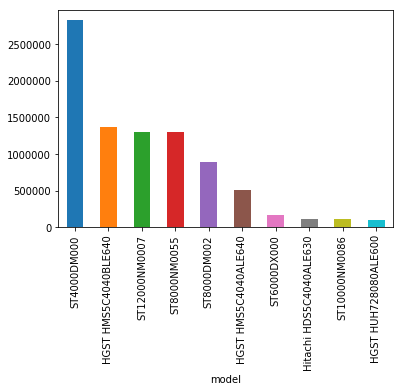

In [61]:
top10_models.plot(kind='bar', legend= False)
print('Top 10 common models and the number of hard Drives in each:')

### Filtering - Limiting the dataset by only top 10 models

In [62]:
# top 10 models
list_top10_models = [i for i in top10_models.index]

# this is the new dataframe based on the top 10 models
new_df = df[df['model'].isin(list_top10_models)]

new_df.shape

(8657708, 19)

---------
#### Using the new dataframe from here on

In [63]:
# Changing datatypes
new_df['failure'] = new_df['failure'].astype('bool')

# saving top10 models data to csv
# new_df.to_csv('top10_models.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


-----
## Analysis

Keeping in mind that the resources available *do not* accurately describe this particular dataset. It is crucial to proceed with caution.

I researched online and read a number of articles. I settled one the ones I found most relevant. I have used this information to help me understand the schema and it's various attributes. 

### Resources: 
These are some of the resources I found helpful. 

1. Understanding differet SMART stats: https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/ 
2. SMART schema on WIKI: https://en.wikipedia.org/wiki/S.M.A.R.T.#ATA_S.M.A.R.T._attributes 
3. Research Paper: http://cs229.stanford.edu/proj2017/final-reports/5242080.pdf


### Tools: 
1. I have utilized scikit library for prediction.
2. Partly used pandas and Google Big Query for faster analysis in SQL, and 
3. matplotlib + Google Data Studio for plotting charts. 

#### Let's check the cardinality of each columns

In [21]:
# find unique values per columns
for cols in new_df.columns:
    print("{} has: {} unique values".format(cols, len(new_df[cols].unique())))

date has: 90 unique values
serial_number has: 101310 unique values
model has: 10 unique values
capacity_bytes has: 5 unique values
failure has: 2 unique values
read_error_rate has: 5938125 unique values
throughput_performance has: 67 unique values
spin_up_time has: 288 unique values
start_stop_count has: 187 unique values
reallocated_sector has: 1023 unique values
seek_time_performance has: 11 unique values
power_on_hours has: 43903 unique values
power_cycle_count has: 123 unique values
reported_uncorrect has: 70 unique values
command_timeout has: 161 unique values
high_fly_writes has: 1175 unique values
airflow_temprature has: 45 unique values
load_cycle_count has: 190691 unique values
total_lbas_written has: 6562030 unique values


### Plotting graphs to get a visual look and analyze
-------
#### Using Google Data Studio and Big Query:

* Google Data Studio provides for a much more robust and interactive reporting system. 
* I loaded the dataset into Big Query and used Google Data Studio because of it's SQL support, interactive platform and robustness with doing exploratory analysis on a large dataset. 
* There are some key charts provided below. 

#### Click Here for a full report: https://datastudio.google.com/open/1vzmbcHsLQ-OMZZsfXUnECJbIteK_kdF7

#### Looking at the trends displayed below, we can derive the following (refer to the Studio Report below) :
     
1. Number of positive Hard drives failure trend are going down. This trend is proportional to the power cycle of the hard drives. This means that as the hard drives get old over time, they are more likely to fail. This is also verified by external sources, a typical life of a hard drive is around 5 years. This can help find out the likelyhood of a drive failing. 


2. Reported uncorrectable errors tend to go down as the failure count goes down over time. On the other hand, the reallocated sectors a going up. Both of these features should ideally be of a lower value for a healthy hard drive. There are higher chances of failure if both of these factors go up in the future.


3. Hard Drives have to reallocated sectors at a much higher rate in the event of a failure. This happens becase hard drives need to remap the data to a different sector in order to avoid data loss. Frequent remapping like this is not a good sign of a healthy hard drive.

4. High fly rates decrease with decrease in failure. This may indicate that a lower high fly rate is a potential sign of healthier hard drives.

There are more exploratory analysis performed on google data studio report, link is provided below. 

In [67]:
# rendering google data studio report
from IPython.display import IFrame
IFrame('https://datastudio.google.com/embed/reporting/1vzmbcHsLQ-OMZZsfXUnECJbIteK_kdF7/page/xJMf', width=900, height=675)

#### Assumptions made and references drawn, in performing the analysis: 
--------

Since there isn't enough detail about the dataset in this case study, some external researching is required to get an understanding. 


There are exponetial values in some of SMART metrics. The provided data stream is raw and there isn't much information available online about different expoential values. I couldn't find a meaningful method to normalize the raw data to a 100 point scale in order to make a better correlation. 

#### Analysis Conclusion
--------------

In conclusion, the metrics in SMART systems are most often high uncorrelated. It wouldn't be recommended to rely on one of them to make a decision about a possible drive failure.

#### (This is Optional)
*In case the above embeded code for Data Studio report failed, I am including local PNG import of some of the charts.*

<table>
<tr>
<td> 1. Number Hard Drives per model
<img src="graphs/hard-drives-per-model.png" width="600"> </td>
    <td>2. Number of positive failures by model
        <img src="graphs/failures-by-model.png" width="600"> </td></tr></table>
        
        
<table>
    <tr>
        <td>3. Failure Trend over time
            <img src="graphs/failure-trend-timeseries.png" width="600"></td>
<td>4. Daily Failure Trend to determine missing failure data pattern
    <img src="graphs/daily-trend-of-fails.png" width="600"></td></tr></table>

------
## Machine learning to Predict Possible Failures based

### Feature selection:

Based on my findings and research on SMART attributes, I have found the following variables to be the most significant out of the total available dataset. The variables are highly non correlated, I made the selection based on what works as a industry standard for SMART predictions.

In [23]:
# get all columns and the number of NaN in them
new_df.isna().sum()

date                            0
serial_number                   0
model                           0
capacity_bytes                  0
failure                         0
read_error_rate                 0
throughput_performance    6579501
spin_up_time                    0
start_stop_count                0
reallocated_sector              0
seek_time_performance     6579501
power_on_hours                  0
power_cycle_count               0
reported_uncorrect        2078207
command_timeout           2078207
high_fly_writes           3374448
airflow_temprature        2078207
load_cycle_count                0
total_lbas_written        2078207
dtype: int64

In [24]:
# new_df.groupby(['model'], as_index=True)['failure'].head()
# failure_by_model = new_df.groupby('failure').agg('model').head()
new_df.shape

(8657708, 19)

In [25]:
# featured selection
# -----------------

# selecting dataframe slice with no nan values.
# first doing a row wise check to see if dropping rows will solve this
featured_df = new_df.dropna(axis=0, how='any', thresh=15)
featured_df.isna().sum()

# there are still three metrics with very high number of nan
# dropping more columns
featured_df = featured_df.drop(['throughput_performance', 'seek_time_performance', 'high_fly_writes'], axis=1)

# final dataframe is ready for any predictive usage
# verify nan in featured_df
featured_df.isna().sum()

date                  0
serial_number         0
model                 0
capacity_bytes        0
failure               0
read_error_rate       0
spin_up_time          0
start_stop_count      0
reallocated_sector    0
power_on_hours        0
power_cycle_count     0
reported_uncorrect    0
command_timeout       0
airflow_temprature    0
load_cycle_count      0
total_lbas_written    0
dtype: int64

In [26]:
# quick look at the featured_df
featured_df.shape

# find unique models per columns
len(featured_df['model'].unique())

6

In [27]:
# number of dates in featured_df
len(featured_df['date'].unique())

90

In [28]:
# number of dates in featured_df
len(featured_df['serial_number'].unique())

76355

In [29]:
# saving feature_df to csv, this is optional. 
# ----------------
# using this to ocassionally push data to Big Query

# this is optional for re-runs
# featured_df.to_csv('featured_hard_drive_dataset.csv', index=False)

In [57]:
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import ensemble, metrics

In [31]:
# load featured hard drive dataset
hdd = pd.read_csv('featured_hard_drive_dataset.csv')

In [32]:
hdd.shape

(6579501, 16)

In [33]:
# number of unique hard drives
hdd['serial_number'].value_counts().shape

# since hard drives serial number is unique across, we use this as the index

(76355,)

In [34]:
# there are 6 models now left in the featured dataset
hdd['model'].value_counts().shape

(6,)

I've used Big Query in parts where I found it easy to do analysis using SQL. Below is the sql script to get % of failure per model
#### SQL to get % of failure per model:
```
SELECT
  model,
  COUNT(DISTINCT serial_number) number_of_hdd,
  SUM(IF(failure IS TRUE,
      1,
      0)) fails,
  ROUND(SUM(IF(failure IS TRUE,
        1,
        0))/COUNT(DISTINCT serial_number),3) percentage_of_fails
FROM

  `orbital-linker-226700.pandey.hard_drive_stats_top10_models`
GROUP BY
  model order by number_of_hdd desc
```

In [69]:
# exported sql output and reading in pandas
sql_output = pd.read_csv('reports/failure_percentage_by_model.csv')
sql_output.head(10)

# This shows that the data is highly imbalanced and the model with most fails is only about .006 or .06% of total data.

,model,number_of_hdd,fails,percentage_of_fails
0,ST4000DM000,32091,178,0.006
1,ST12000NM0007,16833,32,0.002
2,HGST HMS5C4040BLE640,15374,16,0.001
3,ST8000NM0055,14418,28,0.002
4,ST8000DM002,9912,21,0.002
5,HGST HMS5C4040ALE640,6237,8,0.001
6,Hitachi HDS5C4040ALE630,2296,0,0.000
7,ST6000DX000,1882,1,0.001
8,ST10000NM0086,1220,0,0.000
9,HGST HUH728080ALE600,1048,3,0.003


Above: Full list of model their % of failure

In [70]:
# using ST4000DM000	 model
hdd_st4000 = hdd.query('model == "ST4000DM000"')
hdd_st4000.shape

hdd_st4000['serial_number'].value_counts().shape

# number of failures in this hard drive model
hdd_st4000['failure'].value_counts()

False    2822092
True         178
Name: failure, dtype: int64

### Preparing training and testing datasets using dataframe 'hdd'

In [71]:
# using data from all models
# -----------------
date = pd.to_datetime(hdd['date'])
hdd['date'] = date

# add day of year using date column
hdd['day_of_year'] = hdd['date'].dt.dayofyear

# grouping by getting all unique hard drives
# indexing by serial number as every hard drive will have a unique serial number

hdd_group = hdd.groupby('serial_number')

# take the last row from each group
hdd_last_day = hdd_group.nth(-1)


len(hdd_last_day['date'].unique())

29

In [40]:
# total failure per model for one day
hdd_last_day['failure'].value_counts()

# number of drives in the dataset
uniq_serial_numbers = pd.Series(hdd_last_day.index.unique())
uniq_serial_numbers.shape

(76355,)

In [41]:
hdd_last_day['failure'].value_counts()

False    76271
True        84
Name: failure, dtype: int64

In [42]:
# slicing a copy of 25% of all unique hard drives for test
test_ids = uniq_serial_numbers.sample(frac=0.25)
train = hdd_last_day.query('index not in @test_ids')
test = hdd_last_day.query('index in @test_ids')

# test data has now looks like this
test.shape

(19089, 16)

In [43]:
# test data
test['failure'].value_counts()

False    19066
True        23
Name: failure, dtype: int64

In [44]:
train.shape

(57266, 16)

In [45]:
# train data has remaining 24029 data points
train['failure'].value_counts()

False    57205
True        61
Name: failure, dtype: int64

In [46]:
# training and testing labels
train_labels = train['failure']
# failure is the final label we would like to predict 
test_labels = test['failure']

# drop labels from train and test
train = train.drop('failure', axis=1)
test = test.drop('failure', axis=1)

In [47]:
train.shape

(57266, 15)

In [48]:
#drop date related features from tree model
train = train.drop(['day_of_year', 'date'], axis=1)
test = test.drop(['day_of_year', 'date'] , axis=1)

# removing other irrelevant or constant columns

# this is out final training and test dataset with all the right features
train = train.drop(['model', 'capacity_bytes', 'power_on_hours', 'total_lbas_written'], axis=1)
test = test.drop(['model', 'capacity_bytes', 'power_on_hours', 'total_lbas_written'], axis=1)

In [49]:
train.shape

(57266, 9)

In [50]:
# these are the training features
train.columns

Index(['airflow_temprature', 'command_timeout', 'load_cycle_count',
       'power_cycle_count', 'read_error_rate', 'reallocated_sector',
       'reported_uncorrect', 'spin_up_time', 'start_stop_count'],
      dtype='object')

In [51]:
# check first 10 training labels
train_labels[:10]

serial_number
S3000A9T    False
S3000FZ5    False
S3000NSV    False
S3000QAP    False
S30015PW    False
S3001FPA    False
S3001HBH    False
S30034E6    False
S3003A6V    False
S3003GAB    False
Name: failure, dtype: bool

### Prediction using Random Forest Ensemble
For prediction, I tried a couple of options from logistic regression to Naive Bayes but finally settled on random forest classifier tree for following reasons:
1. Data is full of poorly correlated SMART features.
3. For regression, normalization of some of the attributes would be required. 
4. Since there isn't much information available on how different large float values can be normalized, it's a better idea to stick with the absolute numbers only
5. Use raw values instead of normalization since normalization has no impact on performance of a tree.
6. Random forest classifiers are designed to reduce the overall error rate and work over raw data.

#### Overall
There doesn't seem to be a lot of correlation between various SMART attributes, and this varies greatly over different models of hard drive. A decision tree model (random forest) that looks at more than one attribute in order to make a better guess at detecting any future failures. 


In [64]:
rf_clf = ensemble.RandomForestClassifier(n_jobs=1, max_depth=3)

# here's how the random forest object looks
rf_clf.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
# Apply the Classifier we trained to the test data
rf_clf.predict(test)

array([False, False, False, ..., False, False, False])

In [54]:
# generating the predicted values of possible of features for test data using trained rf_clf, generated above
preds = rf_clf.predict_proba(test)

# check predicted values of the first 10 observations
preds[:10]

array([[9.98842063e-01, 1.15793746e-03],
       [9.98980480e-01, 1.01951991e-03],
       [9.99389243e-01, 6.10756587e-04],
       [9.98842063e-01, 1.15793746e-03],
       [9.98842063e-01, 1.15793746e-03],
       [9.98842063e-01, 1.15793746e-03],
       [9.98980480e-01, 1.01951991e-03],
       [9.99256057e-01, 7.43943123e-04],
       [9.98712833e-01, 1.28716695e-03],
       [9.98842063e-01, 1.15793746e-03]])

In [55]:
# performing quick ROC and log loss functions to see how the the data looks

print('ROC Area Under Curve', metrics.roc_auc_score(y_true=test_labels, y_score=preds[:,1]))

ROC Area Under Curve 0.7667108305702389


In [56]:
# performing quick ROC and log loss functions to see how the the data

metrics.roc_auc_score(y_true=test_labels, y_score=preds[:,1])

0.7667108305702389

Since, above tell us that the area under curve is about 0.75, so that's a good enough

### Challenges: 
 1. Highly critical features like throughput_performance', 'seek_time_performance', 'high_fly_writes and 'command_timeout' have a lot of missing data. This makes the training dataset unreliable.
 2. A sound relationship between these uncorrelated metrics/features is needed to better understand things like:
    1. How command_timeout affects retry count or, 
    2. How reallocated sector changes over time as the drive gets old.
    3. Different models are manufactured by different companies, and not all manufacturers have all SMART metrics,
    among other factors like usage, data-center wear and tear, climatic conditions. This makes it difficult to design a general training that would work across the board.
    4. Data is not normalized and there isn't much information on how to normalize them: 
    is the reallocated sector by bits or bytes?
    are all these drives magnetic tapes, hybrid or SSDs?

Normalization would make a much a better regression design, or at least present one such option to do so.


#### Our model accurately predicted about 77% of the time that a drive is likely to fail.

## Business wide High Level Result


----

SMART systems widely used industry practice around data center management and disk heavy resources. 

The above case study attempted to analyze and predict future hard drive failures based on the data that was provided. was to predict hard drive failures using available dataset. 

We identified a few key metrics such as 'throughput_performance', 'reallocated sectors', age of the hard drive using 'power on hours' and a few more. We analyzed their effect over time as the failure rate goes down. 

There was also some extensive researching done leading up to identifying other highly critical metrics but there seems to be missing data about those metrics. Since there isn't enough detail about the dataset in this case study, some external researching was required to get an understanding.

Using provided data, we predicted over 77% of possible failure, but this can be improved further. 

----------

#### Some recommended actions and improvements:
1.	Realistically, since not all Hard Drives are manufactured and used under the same roof it’s a good idea that for future predictions, we use the critical attributes, mentioned above to analyze their effect on per hard drive model instead of a general prediction.
2.	Including more data source: 
a.	Using more than one source of information such as operating temperature, throughput, of reads and writes etc. can help build a more robust collection of data that can predict future.
3.	Backing up drives that are showing critical changes.


## Thanks!

Harsh